In [1524]:
#Import Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [1525]:
#Get value counts for non-numeric object features
object_column_list = list(application_df.select_dtypes(include = "object").columns)
for obj  in object_column_list:
    print(obj + "\n")
    print(application_df[obj].value_counts())
    print("\n")

NAME

PARENT BOOSTER USA INC                                                  1260
TOPS CLUB INC                                                            765
UNITED STATES BOWLING CONGRESS INC                                       700
WASHINGTON STATE UNIVERSITY                                              492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                          408
                                                                        ... 
ST LOUIS SLAM WOMENS FOOTBALL                                              1
AIESEC ALUMNI IBEROAMERICA CORP                                            1
WEALLBLEEDRED ORG INC                                                      1
AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP & PSYCHICAL INVESTIGATI       1
WATERHOUSE CHARITABLE TR                                                   1
Name: NAME, Length: 19568, dtype: int64


APPLICATION_TYPE

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       

In [1526]:
#Get value counts for numeric features
num_column_list = list(application_df.select_dtypes(include = "int64").columns)
for obj  in num_column_list:
    print(obj + "\n")
    print(application_df[obj].value_counts())
    print("\n")

EIN

10520599     1
626274659    1
630475330    1
630416100    1
630357662    1
            ..
383880377    1
383876652    1
383874900    1
383871370    1
996086871    1
Name: EIN, Length: 34299, dtype: int64


STATUS

1    34294
0        5
Name: STATUS, dtype: int64


ASK_AMT

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64


IS_SUCCESSFUL

1    18261
0    16038
Name: IS_SUCCESSFUL, dtype: int64




In [1527]:
#Drop features that are non-pertinent 
application_df = application_df.drop(['EIN', 'SPECIAL_CONSIDERATIONS' ,'STATUS'], axis=1)

In [1528]:
#Bin the ASK_AMT feature which also converts feature to object data type
def replace_ask_amount(x):
    if x >=0 and x <= 100000:
        new = "0-100000"
    elif x > 100000 and x <= 500000:
        new = "100001-500000"
    elif x > 500000 and x <= 1000000:
        new = "500001-1000000"
    elif x > 1000000:
        new = '1000000+'
    return new
new_values = application_df['ASK_AMT'].apply(replace_ask_amount)
application_df['ASK_AMT'] = new_values

In [1529]:
#Bin or re-group indicated feature columns by grouping low-frequency values together into a single value

#Income Amount
rep1 = dict.fromkeys(['1M-5M', '5M-10M', '10M-50M', '50M+'], '1M-50M+')

#Affiliation
rep2 =  dict.fromkeys(['National', 'Regional', 'Family/Parent', 'CompanySponsored'], 'Other')

#Use Case
rep3 =dict.fromkeys(['Heathcare', 'CommunityServ'], 'Other')

#Organization
rep4 = dict.fromkeys(['Co-operative', 'Corporation', 'Association'], 'Other')

#Income Amount 2
rep5 = dict.fromkeys([ '1-9999', '10000-24999'], '1-24999')

application_df = application_df.replace(rep1)
application_df = application_df.replace(rep2)
application_df = application_df.replace(rep3)
application_df = application_df.replace(rep4)
application_df = application_df.replace(rep5)




<AxesSubplot:ylabel='Density'>

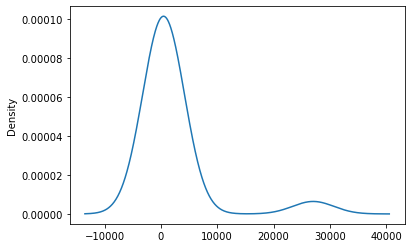

In [1530]:
#Generate density plot of APPLICATION_TYPE feature value counts
application_df['APPLICATION_TYPE'].value_counts().plot.density(ind=1000)

In [1531]:
# Determine which values to replace if counts are less than 100
app_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_apptypes = list(app_counts[app_counts < 100].index)

# Replace in dataframe
for app in replace_apptypes:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
Other      120
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

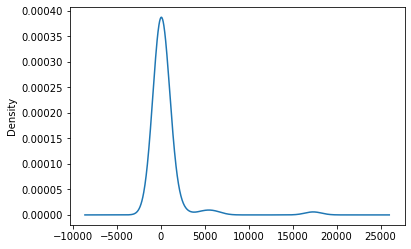

In [1532]:
# Generate density plot of the value counts of CLASSIFICATION feature
application_df['CLASSIFICATION'].value_counts().plot.density(ind=1000)

In [1533]:
# Determine which values to replace if counts are less than 300
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class_counts = list(class_counts[class_counts < 300].index)

# Replace in dataframe
for cls in replace_class_counts:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1484
C7000      777
Name: CLASSIFICATION, dtype: int64

(array([1.9544e+04, 1.2000e+01, 7.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.2690e+02, 2.5280e+02, 3.7870e+02, 5.0460e+02,
        6.3050e+02, 7.5640e+02, 8.8230e+02, 1.0082e+03, 1.1341e+03,
        1.2600e+03]),
 <BarContainer object of 10 artists>)

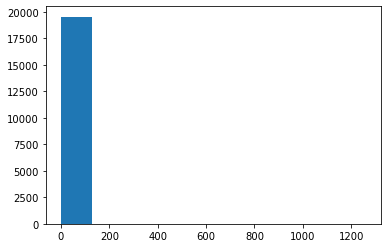

In [1534]:
#Generate a rough histogram of NAME feature value counts
import matplotlib.pyplot as plt
plt.hist(application_df['NAME'].value_counts())

In [1535]:
#Values of 0-100 have highest frequency so these will be grouped 
name_counts = application_df['NAME'].value_counts()
replace_name_counts = list(name_counts[name_counts < 100].index)

# Replace in dataframe
for cls in replace_name_counts:
    application_df.NAME = application_df.NAME.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.NAME.value_counts()

Other                                                                 25987
PARENT BOOSTER USA INC                                                 1260
TOPS CLUB INC                                                           765
UNITED STATES BOWLING CONGRESS INC                                      700
WASHINGTON STATE UNIVERSITY                                             492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                         408
PTA TEXAS CONGRESS                                                      368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC                           331
ALPHA PHI SIGMA                                                         313
TOASTMASTERS INTERNATIONAL                                              293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS                       287
LITTLE LEAGUE BASEBALL INC                                              277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS                                266
MOMS CLUB   

In [1536]:
#View value counts for all of our newly transformed features
object_column_list = list(application_df.select_dtypes(include = "object").columns)
for obj  in object_column_list:
    print(obj + "\n")
    print(application_df[obj].value_counts())
    print("\n")

NAME

Other                                                                 25987
PARENT BOOSTER USA INC                                                 1260
TOPS CLUB INC                                                           765
UNITED STATES BOWLING CONGRESS INC                                      700
WASHINGTON STATE UNIVERSITY                                             492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                         408
PTA TEXAS CONGRESS                                                      368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC                           331
ALPHA PHI SIGMA                                                         313
TOASTMASTERS INTERNATIONAL                                              293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS                       287
LITTLE LEAGUE BASEBALL INC                                              277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS                                266
MOMS C

In [1537]:
# Generate our categorical variable lists
object_column_list = list(application_df.select_dtypes(include = "object").columns)
print(object_column_list)

['NAME', 'APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE', 'ORGANIZATION', 'INCOME_AMT', 'ASK_AMT']


In [1538]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[object_column_list]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(object_column_list)
encode_df.head()

,NAME_ALPHA PHI SIGMA,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN,NAME_CIVITAN INTERNATIONAL,NAME_DEMOLAY INTERNATIONAL,NAME_FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA,NAME_HABITAT FOR HUMANITY INTERNATIONAL INC,NAME_HONOR SOCIETY OF PHI KAPPA PHI,NAME_INTERNATIONAL ASSOCIATION OF LIONS CLUBS,NAME_INTERNATIONAL ASSOCIATION OF SHEET METAL AIR RAIL & TRANSPORTATION,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-24999,INCOME_AMT_100000-499999,INCOME_AMT_1M-50M+,INCOME_AMT_25000-99999,ASK_AMT_0-100000,ASK_AMT_1000000+,ASK_AMT_100001-500000,ASK_AMT_500001-1000000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1539]:
#Merge data frames and drop the original pre-transformed columns
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(object_column_list,axis=1)
application_df.head()

,IS_SUCCESSFUL,NAME_ALPHA PHI SIGMA,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN,NAME_CIVITAN INTERNATIONAL,NAME_DEMOLAY INTERNATIONAL,NAME_FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA,NAME_HABITAT FOR HUMANITY INTERNATIONAL INC,NAME_HONOR SOCIETY OF PHI KAPPA PHI,NAME_INTERNATIONAL ASSOCIATION OF LIONS CLUBS,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-24999,INCOME_AMT_100000-499999,INCOME_AMT_1M-50M+,INCOME_AMT_25000-99999,ASK_AMT_0-100000,ASK_AMT_1000000+,ASK_AMT_100001-500000,ASK_AMT_500001-1000000
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1540]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL']
X = application_df.drop(["IS_SUCCESSFUL"], axis = 1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1541]:
#The following standardscaler steps are unnecessary since all value are now categorical and onehot encoded
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [1547]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
leaky_relu = LeakyReLU(alpha=0.02)
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=120, input_dim=len(X_train[0]), activation=leaky_relu, kernel_initializer="he_normal")
)
nn.add(BatchNormalization())
nn.add(Dropout(0.5))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=120, activation=leaky_relu, kernel_initializer="he_normal"))
nn.add(Dropout(0.5))

#Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_384 (Dense)           (None, 120)               7800      
                                                                 
 batch_normalization_61 (Bat  (None, 120)              480       
 chNormalization)                                                
                                                                 
 dropout_251 (Dropout)       (None, 120)               0         
                                                                 
 dense_385 (Dense)           (None, 120)               14520     
                                                                 
 dropout_252 (Dropout)       (None, 120)               0         
                                                                 
 dense_386 (Dense)           (None, 1)                 121       
                                                    

In [1548]:
#Compile our model
nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [1549]:
# Define the checkpoint path and filenames
os.makedirs("alphabetsoup_charity_optimization_checkpoints/",exist_ok=True)
checkpoint_path = "alphabetsoup_charity_optimization_checkpoints/weights.{epoch:02d}.hdf5"
# Define our Model checkpoint object
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [1550]:
#Fit, Train, and Test our model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100, shuffle=True, callbacks=[cp_callback])
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
  1/804 [..............................] - ETA: 4:05 - loss: 0.6852 - accuracy: 0.5938
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
 15/804 [..............................] - ETA: 2s - loss: 1.2373 - accuracy: 0.5333  
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
 30/804 [>.............................] - ETA: 2s - loss: 1.1555 - accuracy: 0.5562
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to al

350/804 [============>.................] - ETA: 1s - loss: 0.7783 - accuracy: 0.6471
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
364/804 [============>.................] - ETA: 1s - loss: 0.7716 - accuracy: 0.6501
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
375/804 [============>.................] - ETA: 1s - loss: 0.7683 - accuracy: 0.6520
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
390/804 [=============>................] - E


Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
718/804 [=========================>....] - ETA: 0s - loss: 0.6849 - accuracy: 0.6751
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
735/804 [==========================>...] - ETA: 0s - loss: 0.6812 - accuracy: 0.6767
Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5

Epoch 1: saving model to alphabetsoup_charity_optimization_checkpoints\weights.01.hdf5
751/804 [===========================>..]


Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5
276/804 [=========>....................] - ETA: 1s - loss: 0.5582 - accuracy: 0.7132
Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5
296/804 [==========>...................] - ETA: 1s - loss: 0.5561 - accuracy: 0.7146
Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_c

636/804 [======================>.......] - ETA: 0s - loss: 0.5424 - accuracy: 0.7251
Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5
653/804 [=======================>......] - ETA: 0s - loss: 0.5417 - accuracy: 0.7252
Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5
671/804 [========================>.....] - ETA: 0s - loss: 0.5416 - accuracy: 0.7257
Epoch 2: saving model to alphabetsoup_charity_optimization_checkpoints\weights.02.hdf5

Epoch 2: saving model to alphabetsoup_chari


Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5
192/804 [======>.......................] - ETA: 2s - loss: 0.5261 - accuracy: 0.7344
Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5
207/804 [======>.......................] - ETA: 2s - loss: 0.5272 - accuracy: 0.7329
Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5
222/804 [=======>......................] - ETA: 2s - loss: 0.5270 - accuracy: 0.7337
Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_chari


Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5
558/804 [===================>..........] - ETA: 0s - loss: 0.5249 - accuracy: 0.7334
Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5
572/804 [====================>.........] - ETA: 0s - loss: 0.5249 - accuracy: 0.7334
Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5

Epoch 3: saving model to alphabetsoup_charity_optimization_checkpoints\weights.03.hdf5
587/804 [====================>.........] - ETA: 0s - loss: 0.5253 - accuracy: 0.7332
Epoch 3: saving model to alphabetsoup_chari

 94/804 [==>...........................] - ETA: 2s - loss: 0.5266 - accuracy: 0.7314
Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5
109/804 [===>..........................] - ETA: 2s - loss: 0.5318 - accuracy: 0.7268
Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5
123/804 [===>..........................] - ETA: 2s - loss: 0.5279 - accuracy: 0.7299
Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_chari

453/804 [===============>..............] - ETA: 1s - loss: 0.5234 - accuracy: 0.7381
Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5
472/804 [================>.............] - ETA: 1s - loss: 0.5233 - accuracy: 0.7380
Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5
488/804 [=================>............] - ETA: 1s - loss: 0.5233 - accuracy: 0.7378
Epoch 4: saving model to alphabetsoup_charity_optimization_checkpoints\weights.04.hdf5

Epoch 4: saving model to alphabetsoup_chari

  1/804 [..............................] - ETA: 1s - loss: 0.4977 - accuracy: 0.7500
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
 14/804 [..............................] - ETA: 3s - loss: 0.4940 - accuracy: 0.7522
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
 29/804 [>.............................] - ETA: 2s - loss: 0.5007 - accuracy: 0.7446
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_chari


Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
364/804 [============>.................] - ETA: 1s - loss: 0.5164 - accuracy: 0.7418
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
382/804 [=============>................] - ETA: 1s - loss: 0.5177 - accuracy: 0.7404
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
399/804 [=============>................] - ETA: 1s - loss: 0.5191 - accuracy: 0.7404
Epoch 5: saving model to alphabetsoup_chari

724/804 [==========================>...] - ETA: 0s - loss: 0.5157 - accuracy: 0.7430
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
740/804 [==========================>...] - ETA: 0s - loss: 0.5154 - accuracy: 0.7429
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5
754/804 [===========================>..] - ETA: 0s - loss: 0.5164 - accuracy: 0.7418
Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_charity_optimization_checkpoints\weights.05.hdf5

Epoch 5: saving model to alphabetsoup_chari

270/804 [=========>....................] - ETA: 1s - loss: 0.5048 - accuracy: 0.7579
Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5
289/804 [=========>....................] - ETA: 1s - loss: 0.5048 - accuracy: 0.7563
Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5
305/804 [==========>...................] - ETA: 1s - loss: 0.5067 - accuracy: 0.7542
Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_chari


Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5
636/804 [======================>.......] - ETA: 0s - loss: 0.5107 - accuracy: 0.7502
Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5
651/804 [=======================>......] - ETA: 0s - loss: 0.5113 - accuracy: 0.7498
Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5

Epoch 6: saving model to alphabetsoup_charity_optimization_checkpoints\weights.06.hdf5
670/804 [========================>.....] - ETA: 0s - loss: 0.5114 - accuracy: 0.7491
Epoch 6: saving model to alphabetsoup_chari

187/804 [=====>........................] - ETA: 1s - loss: 0.5182 - accuracy: 0.7395
Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5
201/804 [======>.......................] - ETA: 1s - loss: 0.5178 - accuracy: 0.7393
Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5
216/804 [=======>......................] - ETA: 1s - loss: 0.5183 - accuracy: 0.7396
Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_chari


Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5
551/804 [===================>..........] - ETA: 0s - loss: 0.5130 - accuracy: 0.7450
Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5
571/804 [====================>.........] - ETA: 0s - loss: 0.5120 - accuracy: 0.7457
Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5

Epoch 7: saving model to alphabetsoup_charity_optimization_checkpoints\weights.07.hdf5
591/804 [=====================>........]


Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5
109/804 [===>..........................] - ETA: 2s - loss: 0.5039 - accuracy: 0.7342
Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5
127/804 [===>..........................] - ETA: 2s - loss: 0.5101 - accuracy: 0.7335
Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5
146/804 [====>.........................]


Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5
482/804 [================>.............] - ETA: 1s - loss: 0.5117 - accuracy: 0.7455
Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5
497/804 [=================>............] - ETA: 0s - loss: 0.5113 - accuracy: 0.7456
Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_charity_optimization_checkpoints\weights.08.hdf5

Epoch 8: saving model to alphabetsoup_c


Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
 35/804 [>.............................] - ETA: 2s - loss: 0.5034 - accuracy: 0.7554
Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
 53/804 [>.............................] - ETA: 2s - loss: 0.4999 - accuracy: 0.7506
Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
 72/804 [=>............................]


Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
403/804 [==============>...............] - ETA: 1s - loss: 0.5074 - accuracy: 0.7471
Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
420/804 [==============>...............] - ETA: 1s - loss: 0.5069 - accuracy: 0.7473
Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
437/804 [===============>..............] - ETA: 1s - loss: 0.5084 - accuracy: 0.7465
Epoch 9: saving model to alphabetsoup_chari


Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
773/804 [===========================>..] - ETA: 0s - loss: 0.5069 - accuracy: 0.7506
Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
793/804 [============================>.] - ETA: 0s - loss: 0.5074 - accuracy: 0.7501
Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5

Epoch 9: saving model to alphabetsoup_charity_optimization_checkpoints\weights.09.hdf5
804/804 [==============================]

319/804 [==========>...................] - ETA: 1s - loss: 0.5062 - accuracy: 0.7502
Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5
338/804 [===========>..................] - ETA: 1s - loss: 0.5078 - accuracy: 0.7482
Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5
354/804 [============>.................] - ETA: 1s - loss: 0.5068 - accuracy: 0.7490
Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabets


Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5
694/804 [========================>.....] - ETA: 0s - loss: 0.5063 - accuracy: 0.7487
Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5
712/804 [=========================>....] - ETA: 0s - loss: 0.5060 - accuracy: 0.7491
Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5

Epoch 10: saving model to alphabetsoup_charity_optimization_checkpoints\weights.10.hdf5
729/804 [======================


Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5
248/804 [========>.....................] - ETA: 1s - loss: 0.5088 - accuracy: 0.7530
Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5
265/804 [========>.....................] - ETA: 1s - loss: 0.5104 - accuracy: 0.7507
Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5
284/804 [=========>....................] - ETA: 1s - loss: 0.5085 - accuracy: 0.7517
Epoch 11: saving model to alphabets

609/804 [=====================>........] - ETA: 0s - loss: 0.5073 - accuracy: 0.7508
Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5
625/804 [======================>.......] - ETA: 0s - loss: 0.5075 - accuracy: 0.7502
Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5
643/804 [======================>.......] - ETA: 0s - loss: 0.5082 - accuracy: 0.7497
Epoch 11: saving model to alphabetsoup_charity_optimization_checkpoints\weights.11.hdf5

Epoch 11: saving model to alphabets


Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5
171/804 [=====>........................] - ETA: 1s - loss: 0.5020 - accuracy: 0.7504
Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5
188/804 [======>.......................] - ETA: 1s - loss: 0.5014 - accuracy: 0.7528
Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5
206/804 [======>...............

530/804 [==================>...........] - ETA: 0s - loss: 0.5041 - accuracy: 0.7514
Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5
546/804 [===================>..........] - ETA: 0s - loss: 0.5047 - accuracy: 0.7514
Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5
565/804 [====================>.........] - ETA: 0s - loss: 0.5066 - accuracy: 0.7503
Epoch 12: saving model to alphabetsoup_charity_optimization_checkpoints\weights.12.hdf5

Epoch 12: saving model to alphabets


Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5
 87/804 [==>...........................] - ETA: 2s - loss: 0.5124 - accuracy: 0.7507
Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5
104/804 [==>...........................] - ETA: 2s - loss: 0.5056 - accuracy: 0.7563
Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5
121/804 [===>..........................] - ETA: 2s - loss: 0.5045 - accuracy: 0.7577
Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabets


Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5
457/804 [================>.............] - ETA: 1s - loss: 0.5090 - accuracy: 0.7479
Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5
475/804 [================>.............] - ETA: 1s - loss: 0.5084 - accuracy: 0.7486
Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5

Epoch 13: saving model to alphabetsoup_charity_optimization_checkpoints\weights.13.hdf5
492/804 [=================>....

  1/804 [..............................] - ETA: 0s - loss: 0.4512 - accuracy: 0.7500
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
 18/804 [..............................] - ETA: 2s - loss: 0.4797 - accuracy: 0.7604
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
 38/804 [>.............................] - ETA: 2s - loss: 0.4970 - accuracy: 0.7508
Epoch 14: saving model to alphabets


Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
373/804 [============>.................] - ETA: 1s - loss: 0.5073 - accuracy: 0.7481
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
393/804 [=============>................] - ETA: 1s - loss: 0.5076 - accuracy: 0.7479
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
412/804 [==============>.......

737/804 [==========================>...] - ETA: 0s - loss: 0.5047 - accuracy: 0.7522
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
753/804 [===========================>..] - ETA: 0s - loss: 0.5049 - accuracy: 0.7517
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5
772/804 [===========================>..] - ETA: 0s - loss: 0.5045 - accuracy: 0.7517
Epoch 14: saving model to alphabetsoup_charity_optimization_checkpoints\weights.14.hdf5

Epoch 14: saving model to alphabets


Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5
299/804 [==========>...................] - ETA: 1s - loss: 0.5035 - accuracy: 0.7502
Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5
317/804 [==========>...................] - ETA: 1s - loss: 0.5039 - accuracy: 0.7502
Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5
334/804 [===========>..........

652/804 [=======================>......] - ETA: 0s - loss: 0.5057 - accuracy: 0.7506
Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5
669/804 [=======================>......] - ETA: 0s - loss: 0.5055 - accuracy: 0.7506
Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5
688/804 [========================>.....] - ETA: 0s - loss: 0.5051 - accuracy: 0.7507
Epoch 15: saving model to alphabetsoup_charity_optimization_checkpoints\weights.15.hdf5

Epoch 15: saving model to alphabets


Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5
213/804 [======>.......................] - ETA: 1s - loss: 0.5036 - accuracy: 0.7525
Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5
230/804 [=======>......................] - ETA: 1s - loss: 0.5050 - accuracy: 0.7511
Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5
248/804 [========>.....................] - ETA: 1s - loss: 0.5055 - accuracy: 0.7508
Epoch 16: saving model to alphabets

572/804 [====================>.........] - ETA: 0s - loss: 0.5026 - accuracy: 0.7514
Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5
590/804 [=====================>........] - ETA: 0s - loss: 0.5023 - accuracy: 0.7513
Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5
609/804 [=====================>........] - ETA: 0s - loss: 0.5016 - accuracy: 0.7515
Epoch 16: saving model to alphabetsoup_charity_optimization_checkpoints\weights.16.hdf5

Epoch 16: saving model to alphabets

121/804 [===>..........................] - ETA: 2s - loss: 0.5175 - accuracy: 0.7410
Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5
138/804 [====>.........................] - ETA: 2s - loss: 0.5173 - accuracy: 0.7428
Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5
155/804 [====>.........................] - ETA: 1s - loss: 0.5151 - accuracy: 0.7444
Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabets

488/804 [=================>............] - ETA: 0s - loss: 0.5051 - accuracy: 0.7499
Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5
505/804 [=================>............] - ETA: 0s - loss: 0.5056 - accuracy: 0.7494
Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5
521/804 [==================>...........] - ETA: 0s - loss: 0.5049 - accuracy: 0.7497
Epoch 17: saving model to alphabetsoup_charity_optimization_checkpoints\weights.17.hdf5

Epoch 17: saving model to alphabets


Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5
 52/804 [>.............................] - ETA: 2s - loss: 0.4992 - accuracy: 0.7542
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5
 71/804 [=>............................] - ETA: 2s - loss: 0.5003 - accuracy: 0.7588
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alph

407/804 [==============>...............] - ETA: 1s - loss: 0.4977 - accuracy: 0.7548
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5
426/804 [==============>...............] - ETA: 1s - loss: 0.4974 - accuracy: 0.7551
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5
442/804 [===============>..............] - ETA: 1s - loss: 0.4980 - accuracy: 0.7546
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabets

772/804 [===========================>..] - ETA: 0s - loss: 0.5004 - accuracy: 0.7527
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5
791/804 [============================>.] - ETA: 0s - loss: 0.4994 - accuracy: 0.7536
Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5

Epoch 18: saving model to alphabetsoup_charity_optimization_checkpoints\weights.18.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.4999 - accuracy: 0.7534
Epoch 19/100
  1/804 [..............................] - ETA: 2s - loss: 0.4771 - accuracy: 0.7188
Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model


Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5
333/804 [===========>..................] - ETA: 1s - loss: 0.5020 - accuracy: 0.7527
Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5
352/804 [============>.................] - ETA: 1s - loss: 0.5024 - accuracy: 0.7528
Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5
368/804 [============>.................] - ETA: 1s - loss: 0.5031 - accuracy: 0.7523
Epoch 19: saving model to alphabets

697/804 [=========================>....] - ETA: 0s - loss: 0.5013 - accuracy: 0.7519
Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5
713/804 [=========================>....] - ETA: 0s - loss: 0.5017 - accuracy: 0.7511
Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5
732/804 [==========================>...] - ETA: 0s - loss: 0.5016 - accuracy: 0.7511
Epoch 19: saving model to alphabetsoup_charity_optimization_checkpoints\weights.19.hdf5

Epoch 19: saving model to alphabets

248/804 [========>.....................] - ETA: 1s - loss: 0.5024 - accuracy: 0.7500
Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5
264/804 [========>.....................] - ETA: 1s - loss: 0.5021 - accuracy: 0.7499
Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5
283/804 [=========>....................] - ETA: 1s - loss: 0.5032 - accuracy: 0.7482
Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabets


Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5
622/804 [======================>.......] - ETA: 0s - loss: 0.4986 - accuracy: 0.7538
Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5
639/804 [======================>.......] - ETA: 0s - loss: 0.4985 - accuracy: 0.7537
Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5

Epoch 20: saving model to alphabetsoup_charity_optimization_checkpoints\weights.20.hdf5
657/804 [======================


Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5
175/804 [=====>........................] - ETA: 1s - loss: 0.4999 - accuracy: 0.7500
Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5
192/804 [======>.......................] - ETA: 1s - loss: 0.5000 - accuracy: 0.7497
Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5
210/804 [======>...............


Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5
544/804 [===================>..........] - ETA: 0s - loss: 0.4983 - accuracy: 0.7525
Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5
560/804 [===================>..........] - ETA: 0s - loss: 0.4985 - accuracy: 0.7523
Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5

Epoch 21: saving model to alphabetsoup_charity_optimization_checkpoints\weights.21.hdf5
577/804 [====================>.

 84/804 [==>...........................] - ETA: 2s - loss: 0.5038 - accuracy: 0.7500
Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5
101/804 [==>...........................] - ETA: 2s - loss: 0.5059 - accuracy: 0.7478
Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5
119/804 [===>..........................] - ETA: 2s - loss: 0.5053 - accuracy: 0.7479
Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabets


Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5
453/804 [===============>..............] - ETA: 1s - loss: 0.4941 - accuracy: 0.7577
Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5
471/804 [================>.............] - ETA: 1s - loss: 0.4943 - accuracy: 0.7574
Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5

Epoch 22: saving model to alphabetsoup_charity_optimization_checkpoints\weights.22.hdf5
488/804 [=================>............] - ETA: 0s - loss: 0.4943 - accuracy: 0.7570
Epoch 22: saving model to alphabets


Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
 17/804 [..............................] - ETA: 2s - loss: 0.4856 - accuracy: 0.7592
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
 34/804 [>.............................] - ETA: 2s - loss: 0.4959 - accuracy: 0.7537
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alph

367/804 [============>.................] - ETA: 1s - loss: 0.5019 - accuracy: 0.7543
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
382/804 [=============>................] - ETA: 1s - loss: 0.5029 - accuracy: 0.7537
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
399/804 [=============>................] - ETA: 1s - loss: 0.5029 - accuracy: 0.7536
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabets


Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
741/804 [==========================>...] - ETA: 0s - loss: 0.5015 - accuracy: 0.7523
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
757/804 [===========================>..] - ETA: 0s - loss: 0.5011 - accuracy: 0.7522
Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5

Epoch 23: saving model to alphabetsoup_charity_optimization_checkpoints\weights.23.hdf5
774/804 [===========================>..] - ETA: 0s - loss: 0.5003 - accuracy: 0.7527
Epoch 23: saving model to alphabets

288/804 [=========>....................] - ETA: 1s - loss: 0.5033 - accuracy: 0.7524
Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5
305/804 [==========>...................] - ETA: 1s - loss: 0.5012 - accuracy: 0.7538
Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5
323/804 [===========>..................] - ETA: 1s - loss: 0.5016 - accuracy: 0.7546
Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabets


Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5
665/804 [=======================>......] - ETA: 0s - loss: 0.4989 - accuracy: 0.7541
Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5
683/804 [========================>.....] - ETA: 0s - loss: 0.4993 - accuracy: 0.7534
Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5

Epoch 24: saving model to alphabetsoup_charity_optimization_checkpoints\weights.24.hdf5
700/804 [======================

209/804 [======>.......................] - ETA: 1s - loss: 0.4951 - accuracy: 0.7587
Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5
228/804 [=======>......................] - ETA: 1s - loss: 0.4988 - accuracy: 0.7569
Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5
244/804 [========>.....................] - ETA: 1s - loss: 0.5013 - accuracy: 0.7563
Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabets


Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5
582/804 [====================>.........] - ETA: 0s - loss: 0.5003 - accuracy: 0.7539
Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5
599/804 [=====================>........] - ETA: 0s - loss: 0.5001 - accuracy: 0.7541
Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5

Epoch 25: saving model to alphabetsoup_charity_optimization_checkpoints\weights.25.hdf5
616/804 [=====================>........] - ETA: 0s - loss: 0.4995 - accuracy: 0.7543
Epoch 25: saving model to alphabets


Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5
140/804 [====>.........................] - ETA: 2s - loss: 0.4948 - accuracy: 0.7522
Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5
159/804 [====>.........................] - ETA: 2s - loss: 0.4903 - accuracy: 0.7541
Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5
175/804 [=====>................


Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5
509/804 [=================>............] - ETA: 0s - loss: 0.4990 - accuracy: 0.7523
Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5
525/804 [==================>...........] - ETA: 0s - loss: 0.4999 - accuracy: 0.7517
Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5

Epoch 26: saving model to alphabetsoup_charity_optimization_checkpoints\weights.26.hdf5
543/804 [===================>..

 56/804 [=>............................] - ETA: 2s - loss: 0.4942 - accuracy: 0.7612
Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5
 75/804 [=>............................] - ETA: 2s - loss: 0.4896 - accuracy: 0.7654
Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5
 91/804 [==>...........................] - ETA: 2s - loss: 0.4867 - accuracy: 0.7613
Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabets


Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5
426/804 [==============>...............] - ETA: 1s - loss: 0.5042 - accuracy: 0.7489
Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5
445/804 [===============>..............] - ETA: 1s - loss: 0.5033 - accuracy: 0.7498
Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5
461/804 [================>.............] - ETA: 1s - loss: 0.5033 - accuracy: 0.7505
Epoch 27: saving model to alphabets

791/804 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.7546
Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5

Epoch 27: saving model to alphabetsoup_charity_optimization_checkpoints\weights.27.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.4976 - accuracy: 0.7548
Epoch 28/100
  1/804 [..............................] - ETA: 1s - loss: 0.5457 - accuracy: 0.7500
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5
 17/804 [..............................] - ETA: 2s - loss: 0.4829 - accuracy: 0.7702
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model


Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5
352/804 [============>.................] - ETA: 1s - loss: 0.4958 - accuracy: 0.7529
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5
370/804 [============>.................] - ETA: 1s - loss: 0.4968 - accuracy: 0.7530
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5
387/804 [=============>........

715/804 [=========================>....] - ETA: 0s - loss: 0.4974 - accuracy: 0.7546
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5
732/804 [==========================>...] - ETA: 0s - loss: 0.4984 - accuracy: 0.7543
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5
750/804 [==========================>...] - ETA: 0s - loss: 0.4989 - accuracy: 0.7539
Epoch 28: saving model to alphabetsoup_charity_optimization_checkpoints\weights.28.hdf5

Epoch 28: saving model to alphabets


Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5
281/804 [=========>....................] - ETA: 1s - loss: 0.4980 - accuracy: 0.7541
Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5
298/804 [==========>...................] - ETA: 1s - loss: 0.4983 - accuracy: 0.7531
Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alph

636/804 [======================>.......] - ETA: 0s - loss: 0.4974 - accuracy: 0.7528
Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5
653/804 [=======================>......] - ETA: 0s - loss: 0.4970 - accuracy: 0.7529
Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5

Epoch 29: saving model to alphabetsoup_charity_optimization_checkpoints\weights.29.hdf5
673/804 [========================>.....] - ETA: 0s - loss: 0.4964 - accuracy: 0.7535
Epoch 29: saving model to alphabets


Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5
194/804 [======>.......................] - ETA: 1s - loss: 0.4833 - accuracy: 0.7629
Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5
214/804 [======>.......................] - ETA: 1s - loss: 0.4872 - accuracy: 0.7612
Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5
234/804 [=======>..............

554/804 [===================>..........] - ETA: 0s - loss: 0.4932 - accuracy: 0.7571
Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5
572/804 [====================>.........] - ETA: 0s - loss: 0.4937 - accuracy: 0.7567
Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5
589/804 [====================>.........] - ETA: 0s - loss: 0.4936 - accuracy: 0.7569
Epoch 30: saving model to alphabetsoup_charity_optimization_checkpoints\weights.30.hdf5

Epoch 30: saving model to alphabets

114/804 [===>..........................] - ETA: 2s - loss: 0.5005 - accuracy: 0.7527
Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5
130/804 [===>..........................] - ETA: 2s - loss: 0.4999 - accuracy: 0.7541
Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5
149/804 [====>.........................] - ETA: 1s - loss: 0.5033 - accuracy: 0.7496
Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabets


Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5
480/804 [================>.............] - ETA: 0s - loss: 0.4965 - accuracy: 0.7554
Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5
499/804 [=================>............] - ETA: 0s - loss: 0.4957 - accuracy: 0.7554
Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5

Epoch 31: saving model to alphabetsoup_charity_optimization_checkpoints\weights.31.hdf5
515/804 [==================>...........] - ETA: 0s - loss: 0.4947 - accuracy: 0.7554
Epoch 31: saving model to alphabets

 36/804 [>.............................] - ETA: 2s - loss: 0.4991 - accuracy: 0.7569
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
 54/804 [=>............................] - ETA: 2s - loss: 0.5064 - accuracy: 0.7506
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
 71/804 [=>............................] - ETA: 2s - loss: 0.5039 - accuracy: 0.7535
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabets


Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
403/804 [==============>...............] - ETA: 1s - loss: 0.5010 - accuracy: 0.7554
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
421/804 [==============>...............] - ETA: 1s - loss: 0.5001 - accuracy: 0.7562
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
439/804 [===============>..............] - ETA: 1s - loss: 0.4998 - accuracy: 0.7564
Epoch 32: saving model to alphabets


Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
771/804 [===========================>..] - ETA: 0s - loss: 0.4951 - accuracy: 0.7581
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
790/804 [============================>.] - ETA: 0s - loss: 0.4955 - accuracy: 0.7578
Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5

Epoch 32: saving model to alphabetsoup_charity_optimization_checkpoints\weights.32.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.4957 - accuracy: 0.7577
Epoch 33/100
  1/804 [.........


Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5
330/804 [===========>..................] - ETA: 1s - loss: 0.4943 - accuracy: 0.7616
Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5
347/804 [===========>..................] - ETA: 1s - loss: 0.4952 - accuracy: 0.7616
Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alph


Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5
690/804 [========================>.....] - ETA: 0s - loss: 0.4962 - accuracy: 0.7596
Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5
707/804 [=========================>....] - ETA: 0s - loss: 0.4963 - accuracy: 0.7593
Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5

Epoch 33: saving model to alphabetsoup_charity_optimization_checkpoints\weights.33.hdf5
724/804 [==========================>...] - ETA: 0s - loss: 0.4970 - accuracy: 0.7586
Epoch 33: saving model to alphabets


Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5
248/804 [========>.....................] - ETA: 1s - loss: 0.4886 - accuracy: 0.7639
Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5
267/804 [========>.....................] - ETA: 1s - loss: 0.4914 - accuracy: 0.7612
Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5
283/804 [=========>............


Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5
608/804 [=====================>........] - ETA: 0s - loss: 0.4941 - accuracy: 0.7561
Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5
626/804 [======================>.......] - ETA: 0s - loss: 0.4942 - accuracy: 0.7561
Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5

Epoch 34: saving model to alphabetsoup_charity_optimization_checkpoints\weights.34.hdf5
643/804 [======================>.......] - ETA: 0s - loss: 0.4949 - accuracy: 0.7558
Epoch 34: saving model to alphabets


Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5
164/804 [=====>........................] - ETA: 1s - loss: 0.5036 - accuracy: 0.7529
Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5
181/804 [=====>........................] - ETA: 1s - loss: 0.5022 - accuracy: 0.7536
Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5
198/804 [======>.......................] - ETA: 1s - loss: 0.5002 - accuracy: 0.7549
Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabets

528/804 [==================>...........] - ETA: 0s - loss: 0.4964 - accuracy: 0.7553
Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5
544/804 [===================>..........] - ETA: 0s - loss: 0.4975 - accuracy: 0.7544
Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5
560/804 [===================>..........] - ETA: 0s - loss: 0.4965 - accuracy: 0.7546
Epoch 35: saving model to alphabetsoup_charity_optimization_checkpoints\weights.35.hdf5

Epoch 35: saving model to alphabets

 84/804 [==>...........................] - ETA: 2s - loss: 0.5005 - accuracy: 0.7511
Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5
100/804 [==>...........................] - ETA: 2s - loss: 0.4952 - accuracy: 0.7556
Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5
119/804 [===>..........................] - ETA: 2s - loss: 0.4995 - accuracy: 0.7516
Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabets

442/804 [===============>..............] - ETA: 1s - loss: 0.4951 - accuracy: 0.7551
Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5
459/804 [================>.............] - ETA: 1s - loss: 0.4952 - accuracy: 0.7543
Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5
475/804 [================>.............] - ETA: 1s - loss: 0.4958 - accuracy: 0.7539
Epoch 36: saving model to alphabetsoup_charity_optimization_checkpoints\weights.36.hdf5

Epoch 36: saving model to alphabets

Epoch 37/100

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
  1/804 [..............................] - ETA: 7s - loss: 0.5614 - accuracy: 0.7188
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
 19/804 [..............................] - ETA: 2s - loss: 0.5456 - accuracy: 0.7204
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
 36/804 [>.............................] - ETA: 2s - loss: 0.5089 - accuracy: 0.7517
Epoch 37: saving model

358/804 [============>.................] - ETA: 1s - loss: 0.4880 - accuracy: 0.7601
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
376/804 [=============>................] - ETA: 1s - loss: 0.4889 - accuracy: 0.7592
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
393/804 [=============>................] - ETA: 1s - loss: 0.4879 - accuracy: 0.7596
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabets


Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
726/804 [==========================>...] - ETA: 0s - loss: 0.4938 - accuracy: 0.7544
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
743/804 [==========================>...] - ETA: 0s - loss: 0.4940 - accuracy: 0.7540
Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5

Epoch 37: saving model to alphabetsoup_charity_optimization_checkpoints\weights.37.hdf5
761/804 [===========================>..] - ETA: 0s - loss: 0.4946 - accuracy: 0.7534
Epoch 37: saving model to alphabets

277/804 [=========>....................] - ETA: 1s - loss: 0.4961 - accuracy: 0.7534
Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5
292/804 [=========>....................] - ETA: 1s - loss: 0.4972 - accuracy: 0.7517
Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5
307/804 [==========>...................] - ETA: 1s - loss: 0.4981 - accuracy: 0.7508
Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabets


Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5
650/804 [=======================>......] - ETA: 0s - loss: 0.4952 - accuracy: 0.7546
Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5
667/804 [=======================>......] - ETA: 0s - loss: 0.4954 - accuracy: 0.7545
Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5

Epoch 38: saving model to alphabetsoup_charity_optimization_checkpoints\weights.38.hdf5
683/804 [======================

195/804 [======>.......................] - ETA: 1s - loss: 0.4905 - accuracy: 0.7582
Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5
209/804 [======>.......................] - ETA: 1s - loss: 0.4910 - accuracy: 0.7582
Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5
227/804 [=======>......................] - ETA: 1s - loss: 0.4927 - accuracy: 0.7566
Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabets

556/804 [===================>..........] - ETA: 0s - loss: 0.4981 - accuracy: 0.7552
Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5
573/804 [====================>.........] - ETA: 0s - loss: 0.4976 - accuracy: 0.7559
Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5
590/804 [=====================>........] - ETA: 0s - loss: 0.4975 - accuracy: 0.7553
Epoch 39: saving model to alphabetsoup_charity_optimization_checkpoints\weights.39.hdf5

Epoch 39: saving model to alphabets


Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5
118/804 [===>..........................] - ETA: 2s - loss: 0.5076 - accuracy: 0.7373
Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5
134/804 [====>.........................] - ETA: 2s - loss: 0.5057 - accuracy: 0.7383
Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5
151/804 [====>.........................] - ETA: 2s - loss: 0.5040 - accuracy: 0.7403
Epoch 40: saving model to alphabets


Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5
479/804 [================>.............] - ETA: 1s - loss: 0.4971 - accuracy: 0.7537
Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5
499/804 [=================>............] - ETA: 0s - loss: 0.4965 - accuracy: 0.7538
Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5

Epoch 40: saving model to alphabetsoup_charity_optimization_checkpoints\weights.40.hdf5
519/804 [==================>...


Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
 35/804 [>.............................] - ETA: 2s - loss: 0.4956 - accuracy: 0.7679
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
 51/804 [>.............................] - ETA: 2s - loss: 0.4961 - accuracy: 0.7672
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
 70/804 [=>............................] - ETA: 2s - loss: 0.4925 - accuracy: 0.7634
Epoch 41: saving model to alphabets


Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
410/804 [==============>...............] - ETA: 1s - loss: 0.4993 - accuracy: 0.7543
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
429/804 [===============>..............] - ETA: 1s - loss: 0.4999 - accuracy: 0.7538
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alph

760/804 [===========================>..] - ETA: 0s - loss: 0.4961 - accuracy: 0.7555
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
780/804 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.7557
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5

Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
798/804 [============================>.] - ETA: 0s - loss: 0.4960 - accuracy: 0.7559
Epoch 41: saving model to alphabetsoup_charity_optimization_checkpoints\weights.41.hdf5
804/804 [===========================

316/804 [==========>...................] - ETA: 1s - loss: 0.5013 - accuracy: 0.7507
Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5
333/804 [===========>..................] - ETA: 1s - loss: 0.5001 - accuracy: 0.7518
Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5
351/804 [============>.................] - ETA: 1s - loss: 0.4998 - accuracy: 0.7516
Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabets

681/804 [========================>.....] - ETA: 0s - loss: 0.4975 - accuracy: 0.7553
Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5
698/804 [=========================>....] - ETA: 0s - loss: 0.4964 - accuracy: 0.7560
Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5
716/804 [=========================>....] - ETA: 0s - loss: 0.4971 - accuracy: 0.7557
Epoch 42: saving model to alphabetsoup_charity_optimization_checkpoints\weights.42.hdf5

Epoch 42: saving model to alphabets


Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5
251/804 [========>.....................] - ETA: 1s - loss: 0.4885 - accuracy: 0.7617
Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5
267/804 [========>.....................] - ETA: 1s - loss: 0.4893 - accuracy: 0.7614
Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5
285/804 [=========>............


Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5
617/804 [======================>.......] - ETA: 0s - loss: 0.4949 - accuracy: 0.7554
Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5
637/804 [======================>.......] - ETA: 0s - loss: 0.4948 - accuracy: 0.7554
Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alphabetsoup_charity_optimization_checkpoints\weights.43.hdf5

Epoch 43: saving model to alph


Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5
165/804 [=====>........................] - ETA: 2s - loss: 0.4954 - accuracy: 0.7549
Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5
180/804 [=====>........................] - ETA: 2s - loss: 0.4956 - accuracy: 0.7554
Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5
196/804 [======>.......................] - ETA: 2s - loss: 0.4960 - accuracy: 0.7554
Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabets

518/804 [==================>...........] - ETA: 0s - loss: 0.4953 - accuracy: 0.7572
Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5
537/804 [===================>..........] - ETA: 0s - loss: 0.4943 - accuracy: 0.7580
Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5
553/804 [===================>..........] - ETA: 0s - loss: 0.4959 - accuracy: 0.7566
Epoch 44: saving model to alphabetsoup_charity_optimization_checkpoints\weights.44.hdf5

Epoch 44: saving model to alphabets

 70/804 [=>............................] - ETA: 2s - loss: 0.4895 - accuracy: 0.7652
Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5
 88/804 [==>...........................] - ETA: 2s - loss: 0.4895 - accuracy: 0.7631
Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5
104/804 [==>...........................] - ETA: 2s - loss: 0.4908 - accuracy: 0.7602
Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabets


Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5
444/804 [===============>..............] - ETA: 1s - loss: 0.4955 - accuracy: 0.7558
Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5
462/804 [================>.............] - ETA: 1s - loss: 0.4954 - accuracy: 0.7559
Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5

Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5
479/804 [================>.....


Epoch 45: saving model to alphabetsoup_charity_optimization_checkpoints\weights.45.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.4950 - accuracy: 0.7565
Epoch 46/100
  1/804 [..............................] - ETA: 1s - loss: 0.4642 - accuracy: 0.7500
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
 18/804 [..............................] - ETA: 2s - loss: 0.4674 - accuracy: 0.7691
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
 35/804 [>........

355/804 [============>.................] - ETA: 1s - loss: 0.4907 - accuracy: 0.7599
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
375/804 [============>.................] - ETA: 1s - loss: 0.4912 - accuracy: 0.7595
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
393/804 [=============>................] - ETA: 1s - loss: 0.4926 - accuracy: 0.7581
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabets


Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
725/804 [==========================>...] - ETA: 0s - loss: 0.4927 - accuracy: 0.7565
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
741/804 [==========================>...] - ETA: 0s - loss: 0.4937 - accuracy: 0.7562
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5
759/804 [===========================>..] - ETA: 0s - loss: 0.4939 - accuracy: 0.7561
Epoch 46: saving model to alphabetsoup_charity_optimization_checkpoints\weights.46.hdf5

Epoch 46: saving model to alphabets


Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5
290/804 [=========>....................] - ETA: 1s - loss: 0.4953 - accuracy: 0.7522
Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5
306/804 [==========>...................] - ETA: 1s - loss: 0.4972 - accuracy: 0.7506
Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5
322/804 [===========>..........


Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5
656/804 [=======================>......] - ETA: 0s - loss: 0.4924 - accuracy: 0.7574
Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5
676/804 [========================>.....] - ETA: 0s - loss: 0.4932 - accuracy: 0.7574
Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alphabetsoup_charity_optimization_checkpoints\weights.47.hdf5

Epoch 47: saving model to alph


Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5
211/804 [======>.......................] - ETA: 1s - loss: 0.4951 - accuracy: 0.7543
Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5
227/804 [=======>......................] - ETA: 1s - loss: 0.4952 - accuracy: 0.7537
Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5
245/804 [========>.....................] - ETA: 1s - loss: 0.4952 - accuracy: 0.7538
Epoch 48: saving model to alphabets

567/804 [====================>.........] - ETA: 0s - loss: 0.4951 - accuracy: 0.7562
Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5
585/804 [====================>.........] - ETA: 0s - loss: 0.4948 - accuracy: 0.7566
Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5
602/804 [=====================>........] - ETA: 0s - loss: 0.4946 - accuracy: 0.7563
Epoch 48: saving model to alphabetsoup_charity_optimization_checkpoints\weights.48.hdf5

Epoch 48: saving model to alphabets

123/804 [===>..........................] - ETA: 2s - loss: 0.5070 - accuracy: 0.7490
Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5
140/804 [====>.........................] - ETA: 2s - loss: 0.5019 - accuracy: 0.7518
Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5
158/804 [====>.........................] - ETA: 1s - loss: 0.4984 - accuracy: 0.7565
Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabets


Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5
498/804 [=================>............] - ETA: 0s - loss: 0.4958 - accuracy: 0.7553
Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5
517/804 [==================>...........] - ETA: 0s - loss: 0.4952 - accuracy: 0.7567
Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5

Epoch 49: saving model to alphabetsoup_charity_optimization_checkpoints\weights.49.hdf5
533/804 [==================>...


Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
 54/804 [=>............................] - ETA: 2s - loss: 0.4914 - accuracy: 0.7639
Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
 72/804 [=>............................] - ETA: 2s - loss: 0.4827 - accuracy: 0.7648
Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
 89/804 [==>...................


Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
424/804 [==============>...............] - ETA: 1s - loss: 0.4932 - accuracy: 0.7568
Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
443/804 [===============>..............] - ETA: 1s - loss: 0.4936 - accuracy: 0.7567
Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alph

773/804 [===========================>..] - ETA: 0s - loss: 0.4941 - accuracy: 0.7554
Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
789/804 [============================>.] - ETA: 0s - loss: 0.4943 - accuracy: 0.7553
Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5

Epoch 50: saving model to alphabetsoup_charity_optimization_checkpoints\weights.50.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.4947 - accuracy: 0.7551
Epoch 51/100
  1/804 [..............................] - ETA: 1s - loss: 0.5185 - accuracy: 0.8125
Epoch 51: saving model

330/804 [===========>..................] - ETA: 1s - loss: 0.4879 - accuracy: 0.7585
Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5
347/804 [===========>..................] - ETA: 1s - loss: 0.4886 - accuracy: 0.7582
Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5
365/804 [============>.................] - ETA: 1s - loss: 0.4887 - accuracy: 0.7577
Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabets


Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5
704/804 [=========================>....] - ETA: 0s - loss: 0.4931 - accuracy: 0.7572
Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5
720/804 [=========================>....] - ETA: 0s - loss: 0.4930 - accuracy: 0.7572
Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5

Epoch 51: saving model to alphabetsoup_charity_optimization_checkpoints\weights.51.hdf5
740/804 [======================


Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5
264/804 [========>.....................] - ETA: 1s - loss: 0.4943 - accuracy: 0.7573
Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5
281/804 [=========>....................] - ETA: 1s - loss: 0.4950 - accuracy: 0.7554
Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5
299/804 [==========>...........

616/804 [=====================>........] - ETA: 0s - loss: 0.4953 - accuracy: 0.7560
Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5
634/804 [======================>.......] - ETA: 0s - loss: 0.4963 - accuracy: 0.7555
Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5
651/804 [=======================>......] - ETA: 0s - loss: 0.4959 - accuracy: 0.7559
Epoch 52: saving model to alphabetsoup_charity_optimization_checkpoints\weights.52.hdf5

Epoch 52: saving model to alphabets

167/804 [=====>........................] - ETA: 2s - loss: 0.4837 - accuracy: 0.7616
Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5
185/804 [=====>........................] - ETA: 1s - loss: 0.4850 - accuracy: 0.7608
Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5
202/804 [======>.......................] - ETA: 1s - loss: 0.4869 - accuracy: 0.7607
Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabets


Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5
537/804 [===================>..........] - ETA: 0s - loss: 0.4938 - accuracy: 0.7567
Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5
555/804 [===================>..........] - ETA: 0s - loss: 0.4935 - accuracy: 0.7573
Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5

Epoch 53: saving model to alphabetsoup_charity_optimization_checkpoints\weights.53.hdf5
572/804 [====================>.........] - ETA: 0s - loss: 0.4936 - accuracy: 0.7575
Epoch 53: saving model to alphabets

 86/804 [==>...........................] - ETA: 2s - loss: 0.4930 - accuracy: 0.7624
Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5
103/804 [==>...........................] - ETA: 2s - loss: 0.4904 - accuracy: 0.7637
Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5
120/804 [===>..........................] - ETA: 2s - loss: 0.4869 - accuracy: 0.7680
Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabets


Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5
459/804 [================>.............] - ETA: 1s - loss: 0.4933 - accuracy: 0.7576
Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5
477/804 [================>.............] - ETA: 1s - loss: 0.4931 - accuracy: 0.7580
Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5

Epoch 54: saving model to alphabetsoup_charity_optimization_checkpoints\weights.54.hdf5
493/804 [=================>....

  1/804 [..............................] - ETA: 1s - loss: 0.5268 - accuracy: 0.7500
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
 19/804 [..............................] - ETA: 2s - loss: 0.5099 - accuracy: 0.7533
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
 39/804 [>.............................] - ETA: 2s - loss: 0.4919 - accuracy: 0.7596
Epoch 55: saving model to alphabets


Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
376/804 [=============>................] - ETA: 1s - loss: 0.4917 - accuracy: 0.7585
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
394/804 [=============>................] - ETA: 1s - loss: 0.4918 - accuracy: 0.7583
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
412/804 [==============>.......

733/804 [==========================>...] - ETA: 0s - loss: 0.4924 - accuracy: 0.7587
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
749/804 [==========================>...] - ETA: 0s - loss: 0.4932 - accuracy: 0.7586
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5
767/804 [===========================>..] - ETA: 0s - loss: 0.4927 - accuracy: 0.7584
Epoch 55: saving model to alphabetsoup_charity_optimization_checkpoints\weights.55.hdf5

Epoch 55: saving model to alphabets

280/804 [=========>....................] - ETA: 1s - loss: 0.4925 - accuracy: 0.7587
Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5
298/804 [==========>...................] - ETA: 1s - loss: 0.4935 - accuracy: 0.7590
Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5
315/804 [==========>...................] - ETA: 1s - loss: 0.4963 - accuracy: 0.7573
Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabets


Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5
660/804 [=======================>......] - ETA: 0s - loss: 0.4921 - accuracy: 0.7584
Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5
678/804 [========================>.....] - ETA: 0s - loss: 0.4925 - accuracy: 0.7580
Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alphabetsoup_charity_optimization_checkpoints\weights.56.hdf5

Epoch 56: saving model to alph


Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5
209/804 [======>.......................] - ETA: 1s - loss: 0.4920 - accuracy: 0.7567
Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5
226/804 [=======>......................] - ETA: 1s - loss: 0.4932 - accuracy: 0.7555
Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5
245/804 [========>.....................] - ETA: 1s - loss: 0.4936 - accuracy: 0.7548
Epoch 57: saving model to alphabets


Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5
576/804 [====================>.........] - ETA: 0s - loss: 0.4928 - accuracy: 0.7554
Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5
596/804 [=====================>........] - ETA: 0s - loss: 0.4925 - accuracy: 0.7556
Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5

Epoch 57: saving model to alphabetsoup_charity_optimization_checkpoints\weights.57.hdf5
615/804 [=====================>

122/804 [===>..........................] - ETA: 2s - loss: 0.4833 - accuracy: 0.7618
Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5
140/804 [====>.........................] - ETA: 2s - loss: 0.4842 - accuracy: 0.7589
Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5
157/804 [====>.........................] - ETA: 2s - loss: 0.4834 - accuracy: 0.7609
Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabets


Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5
496/804 [=================>............] - ETA: 0s - loss: 0.4912 - accuracy: 0.7575
Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5
512/804 [==================>...........] - ETA: 0s - loss: 0.4920 - accuracy: 0.7567
Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5

Epoch 58: saving model to alphabetsoup_charity_optimization_checkpoints\weights.58.hdf5
532/804 [==================>...


Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
 58/804 [=>............................] - ETA: 2s - loss: 0.4995 - accuracy: 0.7414
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
 78/804 [=>............................] - ETA: 2s - loss: 0.4976 - accuracy: 0.7436
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alph


Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
413/804 [==============>...............] - ETA: 1s - loss: 0.4953 - accuracy: 0.7551
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
431/804 [===============>..............] - ETA: 1s - loss: 0.4962 - accuracy: 0.7544
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
447/804 [===============>..............] - ETA: 1s - loss: 0.4961 - accuracy: 0.7544
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabets


Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
782/804 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.7565
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5

Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
798/804 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.7568
Epoch 59: saving model to alphabetsoup_charity_optimization_checkpoints\weights.59.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.4932 - accuracy: 0.7565
Epoch 60/100
  1/804 [..............................] - ETA: 1s - loss: 0.5110 - accuracy: 0.7188
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model

329/804 [===========>..................] - ETA: 1s - loss: 0.4961 - accuracy: 0.7532
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5
344/804 [===========>..................] - ETA: 1s - loss: 0.4972 - accuracy: 0.7523
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5
359/804 [============>.................] - ETA: 1s - loss: 0.4963 - accuracy: 0.7537
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabets

689/804 [========================>.....] - ETA: 0s - loss: 0.4956 - accuracy: 0.7550
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5
707/804 [=========================>....] - ETA: 0s - loss: 0.4949 - accuracy: 0.7554
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5
724/804 [==========================>...] - ETA: 0s - loss: 0.4944 - accuracy: 0.7559
Epoch 60: saving model to alphabetsoup_charity_optimization_checkpoints\weights.60.hdf5

Epoch 60: saving model to alphabets

240/804 [=======>......................] - ETA: 1s - loss: 0.4900 - accuracy: 0.7594
Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5
257/804 [========>.....................] - ETA: 1s - loss: 0.4912 - accuracy: 0.7588
Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5
275/804 [=========>....................] - ETA: 1s - loss: 0.4909 - accuracy: 0.7592
Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabets


Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5
610/804 [=====================>........] - ETA: 0s - loss: 0.4921 - accuracy: 0.7550
Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5
628/804 [======================>.......] - ETA: 0s - loss: 0.4926 - accuracy: 0.7544
Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5

Epoch 61: saving model to alphabetsoup_charity_optimization_checkpoints\weights.61.hdf5
645/804 [======================

156/804 [====>.........................] - ETA: 2s - loss: 0.4871 - accuracy: 0.7600
Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5
176/804 [=====>........................] - ETA: 1s - loss: 0.4859 - accuracy: 0.7587
Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5
196/804 [======>.......................] - ETA: 1s - loss: 0.4880 - accuracy: 0.7586
Epoch 62: saving model to alphabets


Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5
526/804 [==================>...........] - ETA: 0s - loss: 0.4931 - accuracy: 0.7570
Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5
544/804 [===================>..........] - ETA: 0s - loss: 0.4936 - accuracy: 0.7568
Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5

Epoch 62: saving model to alphabetsoup_charity_optimization_checkpoints\weights.62.hdf5
561/804 [===================>..........] - ETA: 0s - loss: 0.4940 - accuracy: 0.7566
Epoch 62: saving model to alphabets


Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5
 92/804 [==>...........................] - ETA: 2s - loss: 0.4937 - accuracy: 0.7575
Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5
112/804 [===>..........................] - ETA: 2s - loss: 0.4975 - accuracy: 0.7570
Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alph

447/804 [===============>..............] - ETA: 1s - loss: 0.4946 - accuracy: 0.7555
Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5
465/804 [================>.............] - ETA: 1s - loss: 0.4945 - accuracy: 0.7556
Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5
482/804 [================>.............] - ETA: 0s - loss: 0.4937 - accuracy: 0.7569
Epoch 63: saving model to alphabetsoup_charity_optimization_checkpoints\weights.63.hdf5

Epoch 63: saving model to alphabets

  1/804 [..............................] - ETA: 1s - loss: 0.3382 - accuracy: 0.9062
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
 18/804 [..............................] - ETA: 2s - loss: 0.5076 - accuracy: 0.7361
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
 37/804 [>.............................] - ETA: 2s - loss: 0.4908 - accuracy: 0.7627
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabets

366/804 [============>.................] - ETA: 1s - loss: 0.4937 - accuracy: 0.7559
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
383/804 [=============>................] - ETA: 1s - loss: 0.4938 - accuracy: 0.7559
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
402/804 [==============>...............] - ETA: 1s - loss: 0.4931 - accuracy: 0.7559
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabets


Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
741/804 [==========================>...] - ETA: 0s - loss: 0.4919 - accuracy: 0.7580
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
758/804 [===========================>..] - ETA: 0s - loss: 0.4916 - accuracy: 0.7581
Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5

Epoch 64: saving model to alphabetsoup_charity_optimization_checkpoints\weights.64.hdf5
776/804 [======================


Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5
296/804 [==========>...................] - ETA: 1s - loss: 0.4894 - accuracy: 0.7613
Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5
314/804 [==========>...................] - ETA: 1s - loss: 0.4885 - accuracy: 0.7622
Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5
333/804 [===========>..........


Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5
655/804 [=======================>......] - ETA: 0s - loss: 0.4938 - accuracy: 0.7596
Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5
673/804 [========================>.....] - ETA: 0s - loss: 0.4939 - accuracy: 0.7598
Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5

Epoch 65: saving model to alphabetsoup_charity_optimization_checkpoints\weights.65.hdf5
689/804 [========================>.....] - ETA: 0s - loss: 0.4935 - accuracy: 0.7596
Epoch 65: saving model to alphabets


Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5
210/804 [======>.......................] - ETA: 1s - loss: 0.4901 - accuracy: 0.7618
Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5
230/804 [=======>......................] - ETA: 1s - loss: 0.4903 - accuracy: 0.7606
Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5
248/804 [========>.....................] - ETA: 1s - loss: 0.4906 - accuracy: 0.7608
Epoch 66: saving model to alphabets


Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5
576/804 [====================>.........] - ETA: 0s - loss: 0.4890 - accuracy: 0.7606
Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5
594/804 [=====================>........] - ETA: 0s - loss: 0.4897 - accuracy: 0.7599
Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5

Epoch 66: saving model to alphabetsoup_charity_optimization_checkpoints\weights.66.hdf5
610/804 [=====================>........] - ETA: 0s - loss: 0.4907 - accuracy: 0.7593
Epoch 66: saving model to alphabets

126/804 [===>..........................] - ETA: 2s - loss: 0.4786 - accuracy: 0.7661
Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5
144/804 [====>.........................] - ETA: 1s - loss: 0.4800 - accuracy: 0.7654
Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5
161/804 [=====>........................] - ETA: 1s - loss: 0.4836 - accuracy: 0.7636
Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabets

489/804 [=================>............] - ETA: 0s - loss: 0.4925 - accuracy: 0.7586
Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5
506/804 [=================>............] - ETA: 0s - loss: 0.4921 - accuracy: 0.7586
Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5
524/804 [==================>...........] - ETA: 0s - loss: 0.4925 - accuracy: 0.7583
Epoch 67: saving model to alphabetsoup_charity_optimization_checkpoints\weights.67.hdf5

Epoch 67: saving model to alphabets


Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
 52/804 [>.............................] - ETA: 2s - loss: 0.4957 - accuracy: 0.7554
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
 70/804 [=>............................] - ETA: 2s - loss: 0.4978 - accuracy: 0.7558
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alph

402/804 [==============>...............] - ETA: 1s - loss: 0.4916 - accuracy: 0.7572
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
420/804 [==============>...............] - ETA: 1s - loss: 0.4913 - accuracy: 0.7574
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
437/804 [===============>..............] - ETA: 1s - loss: 0.4903 - accuracy: 0.7577
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabets


Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
772/804 [===========================>..] - ETA: 0s - loss: 0.4928 - accuracy: 0.7571
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
789/804 [============================>.] - ETA: 0s - loss: 0.4924 - accuracy: 0.7574
Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5

Epoch 68: saving model to alphabetsoup_charity_optimization_checkpoints\weights.68.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.4929 - accuracy: 0.7566
Epoch 69/100
  1/804 [..............................] - ETA: 1s - loss: 0.4417 - accuracy: 0.8750
Epoch 69: saving model


Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5
333/804 [===========>..................] - ETA: 1s - loss: 0.4901 - accuracy: 0.7572
Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5
352/804 [============>.................] - ETA: 1s - loss: 0.4911 - accuracy: 0.7565
Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5
368/804 [============>.........


Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5
698/804 [=========================>....] - ETA: 0s - loss: 0.4932 - accuracy: 0.7556
Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5
713/804 [=========================>....] - ETA: 0s - loss: 0.4934 - accuracy: 0.7555
Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5
723/804 [=========================>....] - ETA: 0s - loss: 0.4932 - accuracy: 0.7557
Epoch 69: saving model to alphabetsoup_charity_optimization_checkpoints\weights.69.hdf5

Epoch 69: saving model to alphabets


Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5
244/804 [========>.....................] - ETA: 1s - loss: 0.4929 - accuracy: 0.7505
Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5
263/804 [========>.....................] - ETA: 1s - loss: 0.4923 - accuracy: 0.7518
Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5
279/804 [=========>....................] - ETA: 1s - loss: 0.4920 - accuracy: 0.7522
Epoch 70: saving model to alphabets


Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5
609/804 [=====================>........] - ETA: 0s - loss: 0.4917 - accuracy: 0.7568
Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5
627/804 [======================>.......] - ETA: 0s - loss: 0.4913 - accuracy: 0.7575
Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5

Epoch 70: saving model to alphabetsoup_charity_optimization_checkpoints\weights.70.hdf5
644/804 [=======================>......] - ETA: 0s - loss: 0.4914 - accuracy: 0.7574
Epoch 70: saving model to alphabets

164/804 [=====>........................] - ETA: 1s - loss: 0.4936 - accuracy: 0.7550
Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5
180/804 [=====>........................] - ETA: 1s - loss: 0.4954 - accuracy: 0.7536
Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5
199/804 [======>.......................] - ETA: 1s - loss: 0.4962 - accuracy: 0.7533
Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabets

529/804 [==================>...........] - ETA: 0s - loss: 0.4920 - accuracy: 0.7574
Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5
545/804 [===================>..........] - ETA: 0s - loss: 0.4917 - accuracy: 0.7575
Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5
564/804 [====================>.........] - ETA: 0s - loss: 0.4917 - accuracy: 0.7578
Epoch 71: saving model to alphabetsoup_charity_optimization_checkpoints\weights.71.hdf5

Epoch 71: saving model to alphabets


Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5
 86/804 [==>...........................] - ETA: 2s - loss: 0.4868 - accuracy: 0.7631
Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5
104/804 [==>...........................] - ETA: 2s - loss: 0.4896 - accuracy: 0.7608
Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5
121/804 [===>..........................] - ETA: 2s - loss: 0.4877 - accuracy: 0.7601
Epoch 72: saving model to alphabets


Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5
451/804 [===============>..............] - ETA: 1s - loss: 0.4937 - accuracy: 0.7577
Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5
470/804 [================>.............] - ETA: 1s - loss: 0.4943 - accuracy: 0.7566
Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5

Epoch 72: saving model to alphabetsoup_charity_optimization_checkpoints\weights.72.hdf5
486/804 [=================>............] - ETA: 0s - loss: 0.4943 - accuracy: 0.7565
Epoch 72: saving model to alphabets


Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
 17/804 [..............................] - ETA: 2s - loss: 0.5135 - accuracy: 0.7537
Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
 35/804 [>.............................] - ETA: 2s - loss: 0.4923 - accuracy: 0.7589
Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alph

367/804 [============>.................] - ETA: 1s - loss: 0.4893 - accuracy: 0.7620
Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
387/804 [=============>................] - ETA: 1s - loss: 0.4900 - accuracy: 0.7614
Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
407/804 [==============>...............] - ETA: 1s - loss: 0.4918 - accuracy: 0.7597
Epoch 73: saving model to alphabets


Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
738/804 [==========================>...] - ETA: 0s - loss: 0.4918 - accuracy: 0.7573
Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
756/804 [===========================>..] - ETA: 0s - loss: 0.4913 - accuracy: 0.7575
Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5

Epoch 73: saving model to alphabetsoup_charity_optimization_checkpoints\weights.73.hdf5
772/804 [===========================>..] - ETA: 0s - loss: 0.4911 - accuracy: 0.7574
Epoch 73: saving model to alphabets

283/804 [=========>....................] - ETA: 1s - loss: 0.4849 - accuracy: 0.7597
Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5
301/804 [==========>...................] - ETA: 1s - loss: 0.4847 - accuracy: 0.7601
Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5
318/804 [==========>...................] - ETA: 1s - loss: 0.4843 - accuracy: 0.7588
Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabets

652/804 [=======================>......] - ETA: 0s - loss: 0.4914 - accuracy: 0.7560
Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5
668/804 [=======================>......] - ETA: 0s - loss: 0.4922 - accuracy: 0.7556
Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5
684/804 [========================>.....] - ETA: 0s - loss: 0.4923 - accuracy: 0.7552
Epoch 74: saving model to alphabetsoup_charity_optimization_checkpoints\weights.74.hdf5

Epoch 74: saving model to alphabets

201/804 [======>.......................] - ETA: 1s - loss: 0.4848 - accuracy: 0.7615
Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5
218/804 [=======>......................] - ETA: 1s - loss: 0.4871 - accuracy: 0.7615
Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5
234/804 [=======>......................] - ETA: 1s - loss: 0.4897 - accuracy: 0.7597
Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabets


Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5
569/804 [====================>.........] - ETA: 0s - loss: 0.4927 - accuracy: 0.7547
Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5
588/804 [====================>.........] - ETA: 0s - loss: 0.4920 - accuracy: 0.7553
Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5

Epoch 75: saving model to alphabetsoup_charity_optimization_checkpoints\weights.75.hdf5
604/804 [=====================>........] - ETA: 0s - loss: 0.4934 - accuracy: 0.7543
Epoch 75: saving model to alphabets

120/804 [===>..........................] - ETA: 2s - loss: 0.4867 - accuracy: 0.7607
Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5
138/804 [====>.........................] - ETA: 2s - loss: 0.4863 - accuracy: 0.7597
Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5
155/804 [====>.........................] - ETA: 2s - loss: 0.4876 - accuracy: 0.7593
Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabets


Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5
495/804 [=================>............] - ETA: 0s - loss: 0.4920 - accuracy: 0.7564
Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5
515/804 [==================>...........] - ETA: 0s - loss: 0.4912 - accuracy: 0.7575
Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alphabetsoup_charity_optimization_checkpoints\weights.76.hdf5

Epoch 76: saving model to alph


Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
 54/804 [=>............................] - ETA: 2s - loss: 0.4822 - accuracy: 0.7610
Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
 71/804 [=>............................] - ETA: 2s - loss: 0.4788 - accuracy: 0.7650
Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
 88/804 [==>...................


Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
421/804 [==============>...............] - ETA: 1s - loss: 0.4933 - accuracy: 0.7549
Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
440/804 [===============>..............] - ETA: 1s - loss: 0.4926 - accuracy: 0.7548
Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alph


Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
786/804 [============================>.] - ETA: 0s - loss: 0.4897 - accuracy: 0.7574
Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5

Epoch 77: saving model to alphabetsoup_charity_optimization_checkpoints\weights.77.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.4901 - accuracy: 0.7574
Epoch 78/100
  1/804 [..............................] - ETA: 1s - loss: 0.5569 - accuracy: 0.7500
Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving 

331/804 [===========>..................] - ETA: 1s - loss: 0.4870 - accuracy: 0.7619
Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5
347/804 [===========>..................] - ETA: 1s - loss: 0.4878 - accuracy: 0.7617
Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5
364/804 [============>.................] - ETA: 1s - loss: 0.4878 - accuracy: 0.7620
Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabets


Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5
697/804 [=========================>....] - ETA: 0s - loss: 0.4875 - accuracy: 0.7597
Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5
715/804 [=========================>....] - ETA: 0s - loss: 0.4878 - accuracy: 0.7595
Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5

Epoch 78: saving model to alphabetsoup_charity_optimization_checkpoints\weights.78.hdf5
732/804 [======================


Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5
253/804 [========>.....................] - ETA: 1s - loss: 0.4882 - accuracy: 0.7599
Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5
271/804 [=========>....................] - ETA: 1s - loss: 0.4876 - accuracy: 0.7595
Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5
288/804 [=========>....................] - ETA: 1s - loss: 0.4866 - accuracy: 0.7606
Epoch 79: saving model to alphabets


Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5
623/804 [======================>.......] - ETA: 0s - loss: 0.4907 - accuracy: 0.7589
Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5
642/804 [======================>.......] - ETA: 0s - loss: 0.4922 - accuracy: 0.7573
Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5

Epoch 79: saving model to alphabetsoup_charity_optimization_checkpoints\weights.79.hdf5
658/804 [======================

169/804 [=====>........................] - ETA: 2s - loss: 0.4871 - accuracy: 0.7618
Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5
188/804 [======>.......................] - ETA: 1s - loss: 0.4860 - accuracy: 0.7630
Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5
204/804 [======>.......................] - ETA: 1s - loss: 0.4856 - accuracy: 0.7636
Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabets


Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5
537/804 [===================>..........] - ETA: 0s - loss: 0.4929 - accuracy: 0.7565
Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5
549/804 [===================>..........] - ETA: 0s - loss: 0.4932 - accuracy: 0.7563
Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5

Epoch 80: saving model to alphabetsoup_charity_optimization_checkpoints\weights.80.hdf5
569/804 [====================>.........] - ETA: 0s - loss: 0.4927 - accuracy: 0.7563
Epoch 80: saving model to alphabets

 85/804 [==>...........................] - ETA: 2s - loss: 0.4837 - accuracy: 0.7636
Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5
103/804 [==>...........................] - ETA: 2s - loss: 0.4844 - accuracy: 0.7624
Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5
120/804 [===>..........................] - ETA: 2s - loss: 0.4850 - accuracy: 0.7622
Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabets


Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5
464/804 [================>.............] - ETA: 1s - loss: 0.4900 - accuracy: 0.7588
Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5
480/804 [================>.............] - ETA: 0s - loss: 0.4913 - accuracy: 0.7574
Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5

Epoch 81: saving model to alphabetsoup_charity_optimization_checkpoints\weights.81.hdf5
498/804 [=================>....


Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
 18/804 [..............................] - ETA: 2s - loss: 0.4587 - accuracy: 0.7778
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
 36/804 [>.............................] - ETA: 2s - loss: 0.4722 - accuracy: 0.7726
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
 54/804 [=>....................

371/804 [============>.................] - ETA: 1s - loss: 0.4934 - accuracy: 0.7566
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
388/804 [=============>................] - ETA: 1s - loss: 0.4922 - accuracy: 0.7572
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
406/804 [==============>...............] - ETA: 1s - loss: 0.4917 - accuracy: 0.7574
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabets


Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
746/804 [==========================>...] - ETA: 0s - loss: 0.4910 - accuracy: 0.7578
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5
764/804 [===========================>..] - ETA: 0s - loss: 0.4915 - accuracy: 0.7570
Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alphabetsoup_charity_optimization_checkpoints\weights.82.hdf5

Epoch 82: saving model to alph


Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5
297/804 [==========>...................] - ETA: 1s - loss: 0.4912 - accuracy: 0.7544
Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5
314/804 [==========>...................] - ETA: 1s - loss: 0.4906 - accuracy: 0.7550
Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5
332/804 [===========>..........


Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5
660/804 [=======================>......] - ETA: 0s - loss: 0.4907 - accuracy: 0.7571
Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5
677/804 [========================>.....] - ETA: 0s - loss: 0.4914 - accuracy: 0.7565
Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5

Epoch 83: saving model to alphabetsoup_charity_optimization_checkpoints\weights.83.hdf5
696/804 [========================>.....] - ETA: 0s - loss: 0.4912 - accuracy: 0.7570
Epoch 83: saving model to alphabets

211/804 [======>.......................] - ETA: 1s - loss: 0.4828 - accuracy: 0.7620
Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5
228/804 [=======>......................] - ETA: 1s - loss: 0.4840 - accuracy: 0.7622
Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5
247/804 [========>.....................] - ETA: 1s - loss: 0.4853 - accuracy: 0.7620
Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabets

568/804 [====================>.........] - ETA: 0s - loss: 0.4869 - accuracy: 0.7629
Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5
587/804 [====================>.........] - ETA: 0s - loss: 0.4875 - accuracy: 0.7621
Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5
603/804 [=====================>........] - ETA: 0s - loss: 0.4869 - accuracy: 0.7626
Epoch 84: saving model to alphabetsoup_charity_optimization_checkpoints\weights.84.hdf5

Epoch 84: saving model to alphabets

124/804 [===>..........................] - ETA: 2s - loss: 0.4959 - accuracy: 0.7603
Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5
142/804 [====>.........................] - ETA: 2s - loss: 0.4931 - accuracy: 0.7610
Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5
159/804 [====>.........................] - ETA: 1s - loss: 0.4954 - accuracy: 0.7588
Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabets

492/804 [=================>............] - ETA: 0s - loss: 0.4924 - accuracy: 0.7594
Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5
509/804 [=================>............] - ETA: 0s - loss: 0.4920 - accuracy: 0.7601
Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5
527/804 [==================>...........] - ETA: 0s - loss: 0.4932 - accuracy: 0.7591
Epoch 85: saving model to alphabetsoup_charity_optimization_checkpoints\weights.85.hdf5

Epoch 85: saving model to alphabets


Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
 53/804 [>.............................] - ETA: 2s - loss: 0.5005 - accuracy: 0.7482
Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
 70/804 [=>............................] - ETA: 2s - loss: 0.4918 - accuracy: 0.7522
Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
 88/804 [==>...........................] - ETA: 2s - loss: 0.4929 - accuracy: 0.7539
Epoch 86: saving model to alphabets


Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
425/804 [==============>...............] - ETA: 1s - loss: 0.4975 - accuracy: 0.7515
Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
444/804 [===============>..............] - ETA: 1s - loss: 0.4973 - accuracy: 0.7525
Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alph


Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
785/804 [============================>.] - ETA: 0s - loss: 0.4914 - accuracy: 0.7568
Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5

Epoch 86: saving model to alphabetsoup_charity_optimization_checkpoints\weights.86.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.4915 - accuracy: 0.7571
Epoch 87/100

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5
  1/804 [..............................] - ETA: 8s - loss: 0.3859 - accuracy: 0.8750
Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving 

331/804 [===========>..................] - ETA: 1s - loss: 0.4919 - accuracy: 0.7553
Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5
349/804 [============>.................] - ETA: 1s - loss: 0.4942 - accuracy: 0.7541
Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5
366/804 [============>.................] - ETA: 1s - loss: 0.4933 - accuracy: 0.7546
Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabets

700/804 [=========================>....] - ETA: 0s - loss: 0.4910 - accuracy: 0.7566
Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5
716/804 [=========================>....] - ETA: 0s - loss: 0.4913 - accuracy: 0.7564
Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5

Epoch 87: saving model to alphabetsoup_charity_optimization_checkpoints\weights.87.hdf5
736/804 [==========================>...] - ETA: 0s - loss: 0.4909 - accuracy: 0.7571
Epoch 87: saving model to alphabets


Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5
262/804 [========>.....................] - ETA: 1s - loss: 0.4925 - accuracy: 0.7570
Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5
281/804 [=========>....................] - ETA: 1s - loss: 0.4929 - accuracy: 0.7578
Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5
297/804 [==========>...........

617/804 [======================>.......] - ETA: 0s - loss: 0.4906 - accuracy: 0.7607
Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5
636/804 [======================>.......] - ETA: 0s - loss: 0.4917 - accuracy: 0.7601
Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5
652/804 [=======================>......] - ETA: 0s - loss: 0.4917 - accuracy: 0.7602
Epoch 88: saving model to alphabetsoup_charity_optimization_checkpoints\weights.88.hdf5

Epoch 88: saving model to alphabets

172/804 [=====>........................] - ETA: 2s - loss: 0.4861 - accuracy: 0.7633
Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5
188/804 [======>.......................] - ETA: 2s - loss: 0.4878 - accuracy: 0.7625
Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5
205/804 [======>.......................] - ETA: 2s - loss: 0.4908 - accuracy: 0.7605
Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabets


Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5
543/804 [===================>..........] - ETA: 0s - loss: 0.4876 - accuracy: 0.7600
Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5
561/804 [===================>..........] - ETA: 0s - loss: 0.4884 - accuracy: 0.7594
Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5

Epoch 89: saving model to alphabetsoup_charity_optimization_checkpoints\weights.89.hdf5
578/804 [====================>.

 89/804 [==>...........................] - ETA: 2s - loss: 0.4813 - accuracy: 0.7630
Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5
106/804 [==>...........................] - ETA: 2s - loss: 0.4746 - accuracy: 0.7700
Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5
123/804 [===>..........................] - ETA: 2s - loss: 0.4803 - accuracy: 0.7680
Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabets

456/804 [================>.............] - ETA: 1s - loss: 0.4901 - accuracy: 0.7595
Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5
472/804 [================>.............] - ETA: 1s - loss: 0.4894 - accuracy: 0.7599
Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5
489/804 [=================>............] - ETA: 0s - loss: 0.4891 - accuracy: 0.7601
Epoch 90: saving model to alphabetsoup_charity_optimization_checkpoints\weights.90.hdf5

Epoch 90: saving model to alphabets


Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
 19/804 [..............................] - ETA: 2s - loss: 0.4844 - accuracy: 0.7697
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
 35/804 [>.............................] - ETA: 2s - loss: 0.4833 - accuracy: 0.7714
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
 53/804 [>.....................

374/804 [============>.................] - ETA: 1s - loss: 0.4910 - accuracy: 0.7537
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
390/804 [=============>................] - ETA: 1s - loss: 0.4881 - accuracy: 0.7563
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
406/804 [==============>...............] - ETA: 1s - loss: 0.4878 - accuracy: 0.7553
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabets

730/804 [==========================>...] - ETA: 0s - loss: 0.4899 - accuracy: 0.7566
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
750/804 [==========================>...] - ETA: 0s - loss: 0.4896 - accuracy: 0.7565
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5
769/804 [===========================>..] - ETA: 0s - loss: 0.4897 - accuracy: 0.7564
Epoch 91: saving model to alphabetsoup_charity_optimization_checkpoints\weights.91.hdf5

Epoch 91: saving model to alphabets

281/804 [=========>....................] - ETA: 1s - loss: 0.4868 - accuracy: 0.7581
Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5
299/804 [==========>...................] - ETA: 1s - loss: 0.4862 - accuracy: 0.7579
Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5
316/804 [==========>...................] - ETA: 1s - loss: 0.4877 - accuracy: 0.7561
Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabets


Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5
651/804 [=======================>......] - ETA: 0s - loss: 0.4893 - accuracy: 0.7571
Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5
670/804 [========================>.....] - ETA: 0s - loss: 0.4902 - accuracy: 0.7568
Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5

Epoch 92: saving model to alphabetsoup_charity_optimization_checkpoints\weights.92.hdf5
686/804 [========================>.....] - ETA: 0s - loss: 0.4902 - accuracy: 0.7567
Epoch 92: saving model to alphabets

206/804 [======>.......................] - ETA: 1s - loss: 0.4915 - accuracy: 0.7553
Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5
222/804 [=======>......................] - ETA: 1s - loss: 0.4909 - accuracy: 0.7551
Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5
239/804 [=======>......................] - ETA: 1s - loss: 0.4905 - accuracy: 0.7548
Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabets

566/804 [====================>.........] - ETA: 0s - loss: 0.4934 - accuracy: 0.7565
Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5
582/804 [====================>.........] - ETA: 0s - loss: 0.4926 - accuracy: 0.7564
Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5
600/804 [=====================>........] - ETA: 0s - loss: 0.4932 - accuracy: 0.7561
Epoch 93: saving model to alphabetsoup_charity_optimization_checkpoints\weights.93.hdf5

Epoch 93: saving model to alphabets


Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5
121/804 [===>..........................] - ETA: 2s - loss: 0.4873 - accuracy: 0.7601
Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5
138/804 [====>.........................] - ETA: 2s - loss: 0.4851 - accuracy: 0.7618
Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5
156/804 [====>.........................] - ETA: 2s - loss: 0.4886 - accuracy: 0.7592
Epoch 94: saving model to alphabets


Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5
485/804 [=================>............] - ETA: 0s - loss: 0.4919 - accuracy: 0.7552
Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5
503/804 [=================>............] - ETA: 0s - loss: 0.4916 - accuracy: 0.7556
Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5

Epoch 94: saving model to alphabetsoup_charity_optimization_checkpoints\weights.94.hdf5
520/804 [==================>...........] - ETA: 0s - loss: 0.4915 - accuracy: 0.7558
Epoch 94: saving model to alphabets


Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
 39/804 [>.............................] - ETA: 2s - loss: 0.4965 - accuracy: 0.7492
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
 59/804 [=>............................] - ETA: 2s - loss: 0.4947 - accuracy: 0.7511
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
 78/804 [=>............................] - ETA: 2s - loss: 0.4966 - accuracy: 0.7500
Epoch 95: saving model to alphabets

399/804 [=============>................] - ETA: 1s - loss: 0.4898 - accuracy: 0.7617
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
414/804 [==============>...............] - ETA: 1s - loss: 0.4902 - accuracy: 0.7612
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
429/804 [===============>..............] - ETA: 1s - loss: 0.4894 - accuracy: 0.7611
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
443/804 [===============>...........


Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
764/804 [===========================>..] - ETA: 0s - loss: 0.4905 - accuracy: 0.7585
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
783/804 [============================>.] - ETA: 0s - loss: 0.4903 - accuracy: 0.7582
Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5

Epoch 95: saving model to alphabetsoup_charity_optimization_checkpoints\weights.95.hdf5
799/804 [============================>.] - ETA: 0s - loss: 0.4910 - accuracy: 0.7578
Epoch 95: saving model to alphabets


Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5
325/804 [===========>..................] - ETA: 1s - loss: 0.4926 - accuracy: 0.7570
Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5
342/804 [===========>..................] - ETA: 1s - loss: 0.4943 - accuracy: 0.7561
Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5
357/804 [============>.........


Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5
685/804 [========================>.....] - ETA: 0s - loss: 0.4895 - accuracy: 0.7600
Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5
704/804 [=========================>....] - ETA: 0s - loss: 0.4896 - accuracy: 0.7602
Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5

Epoch 96: saving model to alphabetsoup_charity_optimization_checkpoints\weights.96.hdf5
720/804 [======================


Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5
237/804 [=======>......................] - ETA: 1s - loss: 0.4902 - accuracy: 0.7600
Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5
253/804 [========>.....................] - ETA: 1s - loss: 0.4899 - accuracy: 0.7596
Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5
271/804 [=========>....................] - ETA: 1s - loss: 0.4886 - accuracy: 0.7614
Epoch 97: saving model to alphabets


Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5
597/804 [=====================>........] - ETA: 0s - loss: 0.4884 - accuracy: 0.7583
Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5
615/804 [=====================>........] - ETA: 0s - loss: 0.4886 - accuracy: 0.7582
Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5

Epoch 97: saving model to alphabetsoup_charity_optimization_checkpoints\weights.97.hdf5
631/804 [======================>.......] - ETA: 0s - loss: 0.4894 - accuracy: 0.7575
Epoch 97: saving model to alphabets


Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5
156/804 [====>.........................] - ETA: 2s - loss: 0.4914 - accuracy: 0.7602
Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5
172/804 [=====>........................] - ETA: 1s - loss: 0.4925 - accuracy: 0.7591
Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5
191/804 [======>...............


Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5
515/804 [==================>...........] - ETA: 0s - loss: 0.4902 - accuracy: 0.7610
Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5
532/804 [==================>...........] - ETA: 0s - loss: 0.4892 - accuracy: 0.7610
Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5

Epoch 98: saving model to alphabetsoup_charity_optimization_checkpoints\weights.98.hdf5
549/804 [===================>..........] - ETA: 0s - loss: 0.4886 - accuracy: 0.7612
Epoch 98: saving model to alphabets


Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
 68/804 [=>............................] - ETA: 2s - loss: 0.4816 - accuracy: 0.7592
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
 83/804 [==>...........................] - ETA: 2s - loss: 0.4850 - accuracy: 0.7560
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
 98/804 [==>...........................] - ETA: 2s - loss: 0.4883 - accuracy: 0.7541
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabets


Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
430/804 [===============>..............] - ETA: 1s - loss: 0.4911 - accuracy: 0.7560
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
445/804 [===============>..............] - ETA: 1s - loss: 0.4918 - accuracy: 0.7560
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
458/804 [================>.............] - ETA: 1s - loss: 0.4917 - accuracy: 0.7565
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabets

779/804 [============================>.] - ETA: 0s - loss: 0.4926 - accuracy: 0.7571
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
794/804 [============================>.] - ETA: 0s - loss: 0.4922 - accuracy: 0.7575
Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5

Epoch 99: saving model to alphabetsoup_charity_optimization_checkpoints\weights.99.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.4925 - accuracy: 0.7574
Epoch 100/100
  1/804 [..............................] - ETA: 1s - loss: 0.3749 - accuracy: 0.8750
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving

309/804 [==========>...................] - ETA: 1s - loss: 0.4880 - accuracy: 0.7564
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5
324/804 [===========>..................] - ETA: 1s - loss: 0.4880 - accuracy: 0.7556
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5
338/804 [===========>..................] - ETA: 1s - loss: 0.4878 - accuracy: 0.7562
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5
349/804 [===========

651/804 [=======================>......] - ETA: 0s - loss: 0.4917 - accuracy: 0.7549
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5
669/804 [=======================>......] - ETA: 0s - loss: 0.4916 - accuracy: 0.7550
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5
686/804 [========================>.....] - ETA: 0s - loss: 0.4916 - accuracy: 0.7550
Epoch 100: saving model to alphabetsoup_charity_optimization_checkpoints\weights.100.hdf5

Epoch 100: saving m

In [1551]:
#Save our model:
nn.save("alphabetsoupcharity_optimization.h5")